In [2]:
#Required imports

import os
os.system("pip install contractions")
os.system("pip install SpellChecker")
os.system("pip install nltk")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import contractions
import nltk
import itertools
import pickle
from unidecode import unidecode
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import warnings
warnings.filterwarnings("ignore")

In [69]:
#Imports the datasets
df = pd.read_csv('train.csv', sep=",", encoding="utf-8")
df_train = pd.read_csv("train.csv", sep=",", encoding="utf-8")
df_test = pd.read_csv("test.csv", sep=",", encoding="utf-8")

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#Checking Training set's size
df_train.shape

(7613, 5)

In [5]:
#Checking Test set's size
df_test.shape

(3263, 4)

In [6]:
#Checking types of datasets
print(df_train.dtypes)
print("\n")
print(df_test.dtypes)

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


id           int64
keyword     object
location    object
text        object
dtype: object


In [7]:
#Printing an overall understanding about the information in the different columns in the trainingset

for column in df_train.columns:
    print(df_train[column].describe())
    print("\n----------------------------\n")
    
#We see for example that we have 7613 tweets, and that most of them are from USA


count     7613.000000
mean      5441.934848
std       3137.116090
min          1.000000
25%       2734.000000
50%       5408.000000
75%       8146.000000
max      10873.000000
Name: id, dtype: float64

----------------------------

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

----------------------------

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

----------------------------

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

----------------------------

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

----------------

In [8]:
#Checking if any of the datasets have null-values

print("Train Data:\n")
print(df_train.isnull().any())
print("\nTest Data:\n")
print(df_test.isnull().any())

#We see that in the both our sets we have null-values in the "keyword" and the "location" column


Train Data:

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

Test Data:

id          False
keyword      True
location     True
text        False
dtype: bool


In [9]:
#Let's check how many null-values we have in each column

#Training set
print(df_train.isnull().sum())

#Test set
print(df_test.isnull().sum())

#We 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64


<AxesSubplot:ylabel='target'>

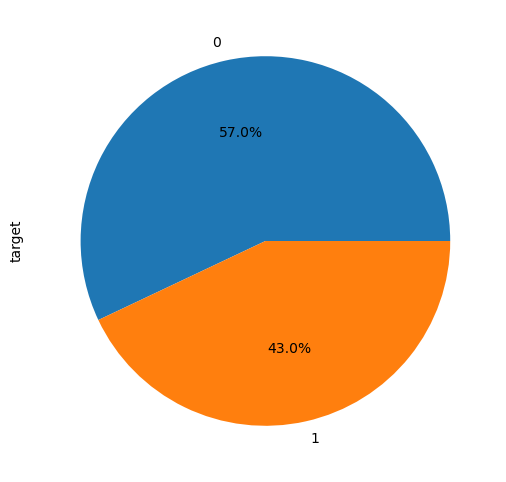

In [10]:
#Visualizing the ratio between normal tweets and real disaster tweets
plt.figure(figsize=(8,6))
round(df_train["target"].value_counts()/df_train.shape[0]*100,2).plot.pie(autopct= '%2.1f%%')

#As we see, there are 57% normal tweets and 43% disaster tweets

<AxesSubplot:title={'center':'Top 20 Keywords'}, xlabel='keyword'>

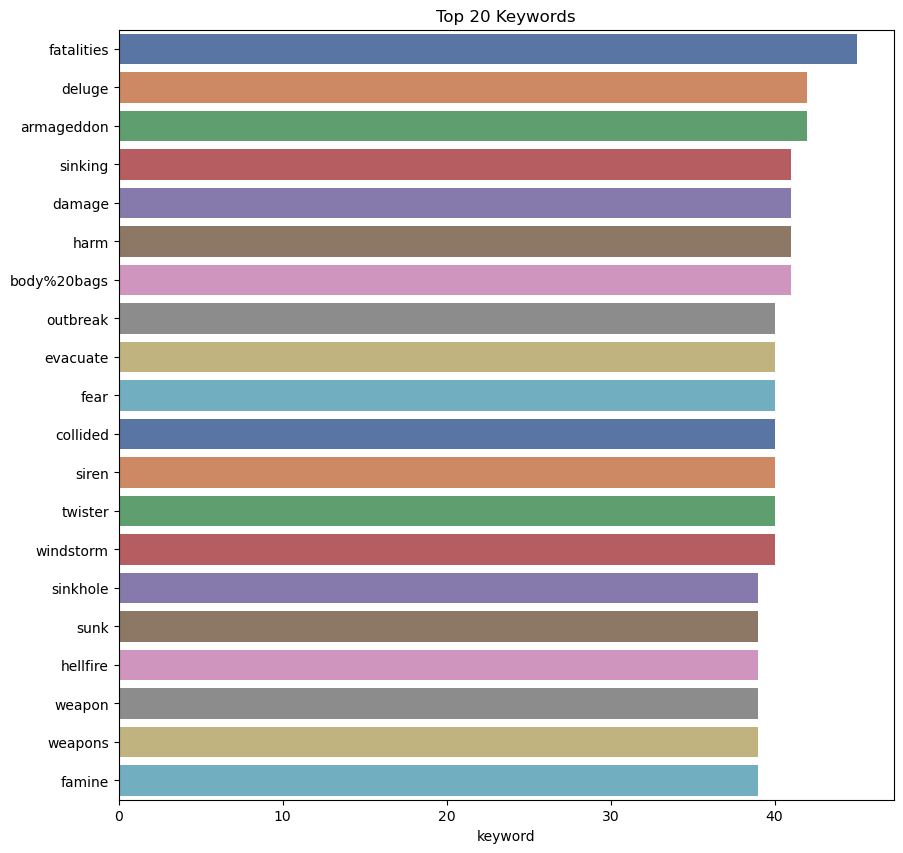

In [11]:
#Visualizing the top 20 most common words in the tweets using .value_counts()

words=df_train['keyword'].value_counts()[:20]
plt.figure(figsize=(10,10))
plt.title("Top 20 Keywords")
plt.xlabel("Count of Keywords")
sns.barplot(x=words,y=words.index,palette='deep')

In [12]:
#Checking if there are any duplicates to remove

print("Training set:")
print(df_train.text.duplicated().sum())
print("\n")
print("Test set:")
print(df_test.text.duplicated().sum())

Training set:
110


Test set:
20


In [13]:
#Removing the duplicates to get a better result for the model

df_train.drop_duplicates(subset=["text"], inplace=True)
df_test.drop_duplicates(subset=["text"], inplace=True)

In [ ]:
#Gjøre om like navn?

In [14]:
#Some tweets don't have a keyword, so I replace all NaN with "None"

df_train.keyword = df_train.keyword.fillna("None")
df_test.keyword = df_test.keyword.fillna("None")

In [18]:
#Performing lemmatizing on the tweets
lemmatizer = WordNetLemmatizer()

#Downloading wordnet
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

#Creating a list that contain all the keywords
keywordList = []
for keyword in df_train.keyword:
    keyword = lemmatizer.lemmatize(keyword)
    if(keyword != "None" and keyword not in keywordList):
        keywordList.append(keyword)
        
print(keywordList)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/Vetlestorvik/nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Vetlestorvik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['ablaze', 'accident', 'aftershock', 'airplane%20accident', 'ambulance', 'annihilated', 'annihilation', 'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging', 'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse', 'buildings%20burning', 'buildings%20on%20fire', 'burned', 'burning', 'burning%20buildings', 'bush%20fires', 'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency', 'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided', 'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage', 'danger', 'dead', 'death', 'debris', 'deluge', 'deluged', 'demolish', 'demolished', 'demolition', 'derail', 'derailed', 'derailment', 'desolate', 'desolation', 'destroy', 'destroyed', 'destruction', 'detonate', 'detonation', 'devastated', 'devas

In [20]:
"""Using the keyword list to replace all the "None"-keywords with
the first word in the tweet that is in the keyword list"""

for text in df_train.text:
    for word in text.split(" "): 
        if(word in keywordList):
            df_train.keyword = df_train.keyword.replace("None", word)
            
for text in df_test.text:
    for word in text.split(" "): 
        if(word in keywordList):
            df_test.keyword = df_test.keyword.replace("None", word)

In [24]:
# I choose to fill in the Na-values for location with a random location from the most common locations
df_train['location'].value_counts().nlargest(25)

#Creating the list of most common locations based on the previuos code
fill_list = ['USA' , 'New York','Canada','London','Nigeria','UK','Los Angeles, CA','India','Mumbai','Kenya','California','Australia','Chicago, IL','Florida','Los Angeles','San Francisco','Indonesia','Washington, D.C.','Ireland']

#Fill in with a random location
df_train['location'] = df_train['location'].fillna(pd.Series(np.random.choice(fill_list , size = len(df_train.index))))
df_test['location'] = df_test['location'].fillna(pd.Series(np.random.choice(fill_list , size = len(df_train.index))))

In [27]:
#Converting all letters in tweets to lower case

df_train.text = df_train.text.str.lower()
df_test.text = df_test.text.str.lower()

df_train.text.head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

In [31]:
#Removing HTML?

"""soup = BeautifulSoup(df_train["text"])
df_train["text"] = soup.get_text()

soup = BeautifulSoup(df_test["text"])
df_test["text"] = soup.get_text()

df_train.head()"""

'soup = BeautifulSoup(df_train["text"])\ndf_train["text"] = soup.get_text()\n\nsoup = BeautifulSoup(df_test["text"])\ndf_test["text"] = soup.get_text()\n\ndf_train.head()'

In [32]:
#In tweets, mentions are commonly used, I therefore choose to remove these

def mentionsRemoval(text):
    pattern = re.compile(r"@\w+")
    text = re.sub(pattern, "", text)
    return text

df_train["text"] = df_train["text"].apply(mentionsRemoval)
df_test["text"] = df_test["text"].apply(mentionsRemoval)
df_train.head()

,id,keyword,location,text,target
0,1,fire,"Chicago, IL",our deeds are the reason of this #earthquake m...,1
1,4,fire,California,forest fire near la ronge sask. canada,1
2,5,fire,"Chicago, IL",all residents asked to 'shelter in place' are ...,1
3,6,fire,Australia,"13,000 people receive #wildfires evacuation or...",1
4,7,fire,Nigeria,just got sent this photo from ruby #alaska as ...,1


In [33]:
#Removing URLs

def urlRemoval(text):
    pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    text = re.sub(pattern, "", text)
    return text

df_train["text"] = df_train["text"].apply(urlRemoval)
df_test["text"] = df_test["text"].apply(urlRemoval)
df_train.head()

,id,keyword,location,text,target
0,1,fire,"Chicago, IL",our deeds are the reason of this #earthquake m...,1
1,4,fire,California,forest fire near la ronge sask. canada,1
2,5,fire,"Chicago, IL",all residents asked to 'shelter in place' are ...,1
3,6,fire,Australia,"13,000 people receive #wildfires evacuation or...",1
4,7,fire,Nigeria,just got sent this photo from ruby #alaska as ...,1


In [34]:
#Removing emails

def emailRemoval(text):
    pattern = re.compile(r"[\w\.-]+@[\w\.-]+\.\w+")
    text = re.sub(pattern, "", text)
    return text

df_train["text"] = df_train["text"].apply(emailRemoval)
df_test["text"] = df_test["text"].apply(emailRemoval)
df_train.head()

,id,keyword,location,text,target
0,1,fire,"Chicago, IL",our deeds are the reason of this #earthquake m...,1
1,4,fire,California,forest fire near la ronge sask. canada,1
2,5,fire,"Chicago, IL",all residents asked to 'shelter in place' are ...,1
3,6,fire,Australia,"13,000 people receive #wildfires evacuation or...",1
4,7,fire,Nigeria,just got sent this photo from ruby #alaska as ...,1


In [35]:
#Removing all the puntuations in the method, string.punctuation:  !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~

def punctuationsRemoval(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text

df_train["text"] = df_train["text"].apply(punctuationsRemoval)
df_test["text"] = df_test["text"].apply(punctuationsRemoval)
df_train.head()

,id,keyword,location,text,target
0,1,fire,"Chicago, IL",our deeds are the reason of this earthquake m...,1
1,4,fire,California,forest fire near la ronge sask canada,1
2,5,fire,"Chicago, IL",all residents asked to shelter in place are ...,1
3,6,fire,Australia,13 000 people receive wildfires evacuation or...,1
4,7,fire,Nigeria,just got sent this photo from ruby alaska as ...,1


In [36]:
#Removing numbers in tweets

def digitsRemoval(text):
    pattern = re.compile("\w*\d+\w*")
    text = re.sub(pattern, "",text)
    return text

df_train["text"] = df_train["text"].apply(digitsRemoval)
df_test["text"] = df_test["text"].apply(digitsRemoval)
df_train.head()

,id,keyword,location,text,target
0,1,fire,"Chicago, IL",our deeds are the reason of this earthquake m...,1
1,4,fire,California,forest fire near la ronge sask canada,1
2,5,fire,"Chicago, IL",all residents asked to shelter in place are ...,1
3,6,fire,Australia,people receive wildfires evacuation orders ...,1
4,7,fire,Nigeria,just got sent this photo from ruby alaska as ...,1


In [37]:
#Removing emojis

def removeEmoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df_train['text'] = df_train['text'].apply(lambda x: removeEmoji(x))
df_test['text'] = df_test['text'].apply(lambda x: removeEmoji(x))
df_train.head(10)

,id,keyword,location,text,target
0,1,fire,"Chicago, IL",our deeds are the reason of this earthquake m...,1
1,4,fire,California,forest fire near la ronge sask canada,1
2,5,fire,"Chicago, IL",all residents asked to shelter in place are ...,1
3,6,fire,Australia,people receive wildfires evacuation orders ...,1
4,7,fire,Nigeria,just got sent this photo from ruby alaska as ...,1
5,8,fire,Indonesia,rockyfire update california hwy closed i...,1
6,10,fire,California,flood disaster heavy rain causes flash flood...,1
7,13,fire,Canada,i m on top of the hill and i can see a fire in...,1
8,14,fire,Canada,there s an emergency evacuation happening now ...,1
9,15,fire,Kenya,i m afraid that the tornado is coming to our a...,1


In [39]:
#Remove Engilsh stopwords

nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

def stopwordsRemoval(text):
    return " ".join([word for word in str(text).split() if word not in stopWords])

df_train["text"] = df_train["text"].apply(stopwordsRemoval)
df_test["text"] = df_test["text"].apply(stopwordsRemoval)
df_train.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Vetlestorvik/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,target
0,1,fire,"Chicago, IL",deeds reason earthquake may allah forgive us,1
1,4,fire,California,forest fire near la ronge sask canada,1
2,5,fire,"Chicago, IL",residents asked shelter place notified officer...,1
3,6,fire,Australia,people receive wildfires evacuation orders cal...,1
4,7,fire,Nigeria,got sent photo ruby alaska smoke wildfires pou...,1


In [41]:
#Perform stemming

lemmatizer = WordNetLemmatizer()
def textLemmatizer(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text

df_train["text"] = df_train["text"].apply(textLemmatizer)
df_test["text"] = df_test["text"].apply(textLemmatizer)
df_train.head()

,id,keyword,location,text,target
0,1,fire,"Chicago, IL",deed reason earthquake may allah forgive u,1
1,4,fire,California,forest fire near la ronge sask canada,1
2,5,fire,"Chicago, IL",resident asked shelter place notified officer ...,1
3,6,fire,Australia,people receive wildfire evacuation order calif...,1
4,7,fire,Nigeria,got sent photo ruby alaska smoke wildfire pour...,1


In [44]:
#Make sure all data are strings

df_train.tweet = df_train.text.astype("string")
df_train.keyword = df_train.keyword.astype("string")
df_train.location = df_train.location.astype("string")

df_test.tweet = df_test.text.astype("string")
df_test.keyword = df_test.keyword.astype("string")
df_test.location = df_test.location.astype("string")

In [57]:
# Defining a result function that displays the result of the different models
#Reference: http://localhost:8888/notebooks/Python_code.ipynb#

def resultsSummarizer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary')
    rec = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    
    plt.figure(figsize=(7, 7))
    
    sns.heatmap(cm,
                annot=True,
                cmap='Blues',
               )
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Tweet')
    plt.ylabel('Actual Tweet')
    plt.show()
    
    print(f'Accuracy Score: ' + '{:.4%}'.format(acc))
    print(f'Precision Score: ' + '{:.4%}'.format(prec))
    print(f'Recall Score: ' + '{:.4%}'.format(rec))
    print(f'F_1 Score: ' + '{:.4%}'.format(f1))

In [70]:
#Splitting full dataset in training and test set

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_train['text'])
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

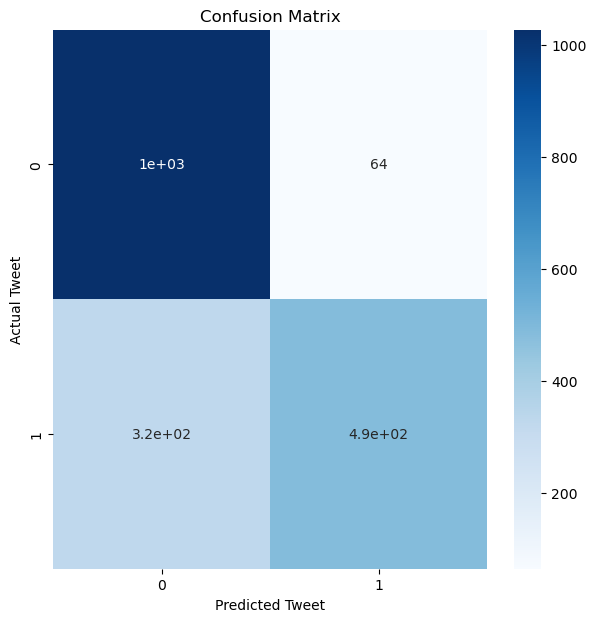

Accuracy Score: 79.5693%
Precision Score: 88.4058%
Recall Score: 60.0246%
F_1 Score: 71.5018%


In [91]:
#Random Forest Classifier Model
rfst = RandomForestClassifier(n_estimators=100, random_state=42)
rfst.fit(X_train, y_train)

y_pred_rfst = rfst.predict(X_test)
resultsSummarizer(y_test, y_pred_rfst)

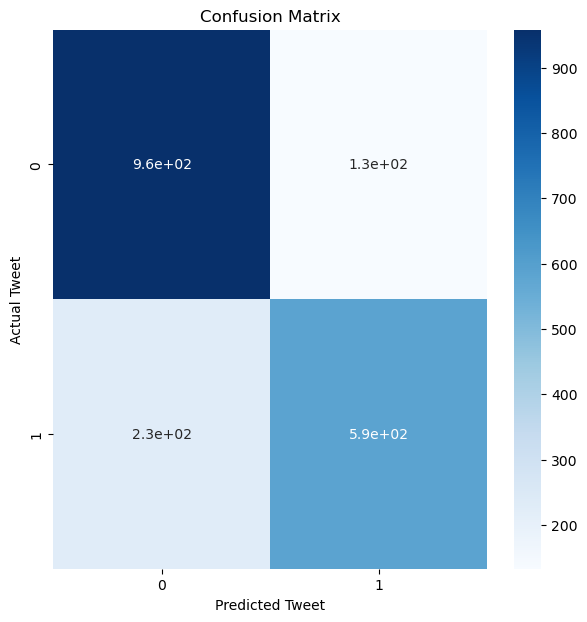

Accuracy Score: 81.0924%
Precision Score: 81.5021%
Recall Score: 72.0787%
F_1 Score: 76.5013%


In [59]:
#Logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

resultsSummarizer(y_test, y_pred_lr)

In [81]:
#Decision Tree Classifier
dt=DecisionTreeClassifier(max_depth=23)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=23)

In [103]:
#Submission

submission = df_test[["id"]][:1904]
submission["target"] = y_pred_rfst
submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,0
...,...,...
1899,6409,0
1900,6411,1
1901,6419,1
1902,6424,0
